In [2]:
# Filter all warnings.
# A recent matplotlib update around October 2015 causes various 
# spurious warnings.
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import scipy as sp
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph
import sklearn as sk
import sklearn.metrics as skm
import sklearn.cluster as skc
import sklearn.decomposition as skd
import sklearn.mixture as skmix
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)

# 1. Guided Analysis

Assume you are a data scientist working for a large retail chain company. Your team is working on identifying strategies to improve alcohol sales in a certain area. You are given a dataset of alcohol-buying customers as below, and you are asked to perform clustering analysis to explore what different types of customers there are, so that later on different strategies can be developed for different customer groups.

a) Load data

In [4]:
df = pd.read_csv('si-370-hw7-df.csv')
df

,CustomerID,Gender,Payment,FavoriteProduct,Age,Income,HouseholdSize,Sales,StoreVisit
0,121,Female,Cash,Beer,42,65000,4,20,1
1,123,Male,Cash,Spirit,60,45000,2,300,10
2,154,Male,Debit,Beer,21,21000,1,46,18
3,166,Male,Cash,Spirit,72,48000,2,290,11
4,170,Female,Credit,Wine,36,90000,5,190,4
5,198,Female,Debit,Wine,34,85000,4,180,6
6,199,Male,Credit,Spirit,41,75000,2,15,1
7,205,Male,Cash,Wine,26,65000,1,20,2
8,222,Male,Cash,Spirit,21,21000,1,75,21
9,239,Female,Credit,Spirit,35,75000,4,200,5


(b) Filter the data by dropping the rows where StoreVisit is smaller than 3. This is because we want to focus on customers for whom we have sufficient data. For subsequent questions, use the filtered data.

In [5]:
df_filt = df[(df.StoreVisit >= 3)]

In [6]:
df_filt = df_filt.set_index('CustomerID')
df_filt

,Gender,Payment,FavoriteProduct,Age,Income,HouseholdSize,Sales,StoreVisit
CustomerID,,,,,,,,
123,Male,Cash,Spirit,60,45000,2,300,10
154,Male,Debit,Beer,21,21000,1,46,18
166,Male,Cash,Spirit,72,48000,2,290,11
170,Female,Credit,Wine,36,90000,5,190,4
198,Female,Debit,Wine,34,85000,4,180,6
222,Male,Cash,Spirit,21,21000,1,75,21
239,Female,Credit,Spirit,35,75000,4,200,5
268,Male,Debit,Spirit,68,44000,2,280,13
293,Male,Debit,Beer,23,30000,1,60,22


(c) Convert categorical variables (columns) into binary variables. This is for the convenience of calculating distance between customers later on. There are three categorical variables that need to be converted. Create a new column for each unique value of each categorical variable.

In [7]:
gender = pd.get_dummies(df_filt['Gender'])
payment = pd.get_dummies(df_filt['Payment'])
fav = pd.get_dummies(df_filt['FavoriteProduct'])

df_filt['Female'] = gender.Female
df_filt['Male'] = gender.Male
df_filt['Cash'] = payment.Cash
df_filt['Credit'] = payment.Credit
df_filt['Debit'] = payment.Debit
df_filt['Beer'] = fav.Beer
df_filt['Spirit'] = fav.Spirit
df_filt['Wine'] = fav.Wine
df_filt.drop('Gender', axis=1, inplace=True)
df_filt.drop('Payment', axis=1, inplace=True)
df_filt.drop('FavoriteProduct', axis=1, inplace=True)

df_filt_2 = df_filt.copy()
df_filt.head()


,Age,Income,HouseholdSize,Sales,StoreVisit,Female,Male,Cash,Credit,Debit,Beer,Spirit,Wine
CustomerID,,,,,,,,,,,,,
123,60,45000,2,300,10,0,1,1,0,0,0,1,0
154,21,21000,1,46,18,0,1,0,0,1,1,0,0
166,72,48000,2,290,11,0,1,1,0,0,0,1,0
170,36,90000,5,190,4,1,0,0,1,0,0,0,1
198,34,85000,4,180,6,1,0,0,0,1,0,0,1


(d) Normalize all data columns, so that each column has a mean of 0 and a standard deviation of 1. Data normalization is important to clustering analysis: without normalization, columns like "Income" will dominate the distance calculation between customers (because of its scale), whereas we want every column to exert a comparable amount of influence in calculating the distance.

For example, for the Income column, you need to calculate mean and standard deviation (std), and each data point should be normalized as
Income_normalized = (Income - mean(Income)) / std(Income)

In [8]:
#income_normalized = (df_filt['Income'] - df_filt['Income'].mean()) / df_filt['Income'].std()
#income_normalized

import sklearn.preprocessing as skp


df_filt[:] = skp.scale(df_filt, axis=0, with_mean=True, with_std=True, copy=True)
df_filt.head()

,Age,Income,HouseholdSize,Sales,StoreVisit,Female,Male,Cash,Credit,Debit,Beer,Spirit,Wine
CustomerID,,,,,,,,,,,,,
123,1.249267,-0.093319,-0.294884,1.379292,-0.560666,-0.935414,0.935414,1.069045,-0.5,-0.707107,-0.816497,1.414214,-0.603023
154,-0.875213,-0.856837,-1.032094,-1.100700,0.708767,-0.935414,0.935414,-0.935414,-0.5,1.414214,1.224745,-0.707107,-0.603023
166,1.902952,0.002121,-0.294884,1.281654,-0.401987,-0.935414,0.935414,1.069045,-0.5,-0.707107,-0.816497,1.414214,-0.603023
170,-0.058105,1.338277,1.916745,0.305280,-1.512741,1.069045,-1.069045,-0.935414,2.0,-0.707107,-0.816497,-0.707107,1.658312
198,-0.167053,1.179211,1.179536,0.207642,-1.195382,1.069045,-1.069045,-0.935414,-0.5,1.414214,-0.816497,-0.707107,1.658312


e) Perform hierarchical clustering on the customers. Observe the following requirements...

In [55]:
#Use Euclidean distance
dist_filt = spd.squareform(spd.pdist(df_filt, metric='euclidean'))
dist_filt.shape

(15, 15)

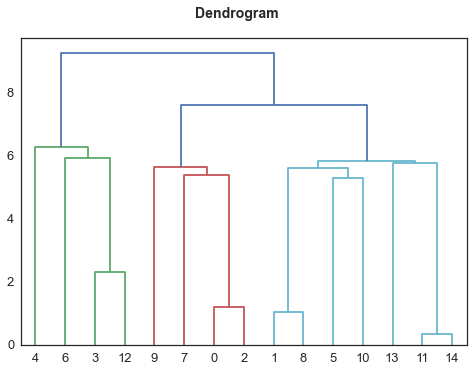

In [56]:
#Use "single" linkage function
#Plot dendrogram
Z_filt = sph.linkage(dist_filt, method='single')  # obtain the linkage matrix
_ = sph.dendrogram(Z_filt)  # plot the linkage matrix as a dendrogram
plt.xlabel('')
plt.ylabel('')
plt.suptitle('Dendrogram', 
             fontweight='bold', fontsize=14);

In [57]:
#Pick a distance threshold based on the dendrogram, and argue why it is a reasonable threshold
cluster_labels = sph.fcluster(Z_filt, 7.0, criterion='distance')
df_filt['cluster_label'] = cluster_labels
df_filt

,Age,Income,HouseholdSize,Sales,StoreVisit,Female,Male,Cash,Credit,Debit,Beer,Spirit,Wine,cluster_label
CustomerID,,,,,,,,,,,,,,
123,1.249267,-0.093319,-0.294884,1.379292,-0.560666,-0.935414,0.935414,1.069045,-0.5,-0.707107,-0.816497,1.414214,-0.603023,2
154,-0.875213,-0.856837,-1.032094,-1.100700,0.708767,-0.935414,0.935414,-0.935414,-0.5,1.414214,1.224745,-0.707107,-0.603023,3
166,1.902952,0.002121,-0.294884,1.281654,-0.401987,-0.935414,0.935414,1.069045,-0.5,-0.707107,-0.816497,1.414214,-0.603023,2
170,-0.058105,1.338277,1.916745,0.305280,-1.512741,1.069045,-1.069045,-0.935414,2.0,-0.707107,-0.816497,-0.707107,1.658312,1
198,-0.167053,1.179211,1.179536,0.207642,-1.195382,1.069045,-1.069045,-0.935414,-0.5,1.414214,-0.816497,-0.707107,1.658312,1
222,-0.875213,-0.856837,-1.032094,-0.817551,1.184804,-0.935414,0.935414,1.069045,-0.5,-0.707107,-0.816497,1.414214,-0.603023,3
239,-0.112579,0.861078,1.179536,0.402917,-1.354061,1.069045,-1.069045,-0.935414,2.0,-0.707107,-0.816497,1.414214,-0.603023,1
268,1.685057,-0.125132,-0.294884,1.184017,-0.084629,-0.935414,0.935414,-0.935414,-0.5,1.414214,-0.816497,1.414214,-0.603023,2
293,-0.766265,-0.570517,-1.032094,-0.964007,1.343483,-0.935414,0.935414,-0.935414,-0.5,1.414214,1.224745,-0.707107,-0.603023,3


7.0 is a reasonable threshold because looking at the dendrogram there are clearly 3 clusters and 7.0 identifies the three clusters with the same number of customers in each as seen on the dendrogram.

In [11]:
#Given the selected threshold, for each cluster, report which customers (CustomerID) fall in the cluster.
#For example, "Cluster 1 has three customers: 123, 154, 166; ....".

Cluster 1 has 4 customers: 170, 198, 239, 384

Cluster 2 has 4 customers: 123, 166, 268, 332

Cluster 3 has 7 customers: 154, 222, 293, 334, 335, 537, 584



In [12]:
#Evaluate the clustering result using an appropriate metric. 
#Hint: there is no ground truth for this problem, so you may want to choose an evaluation measurement accordingly
metrics = ['Age', 'Income', 'HouseholdSize', 'Sales', 'StoreVisit']
X = df_filt[metrics]  # Use all four metrics for the iris dataset
kmeans_model = skc.KMeans(n_clusters=3, random_state=0).fit(X)
silh_score = skm.silhouette_score(X, kmeans_model.labels_)
silh_score  # the Silhouette coefficient

0.77306299603876349

(f) Perform k-means clustering on the customers. Use k = 2, 3, 4, and 5 respectively.

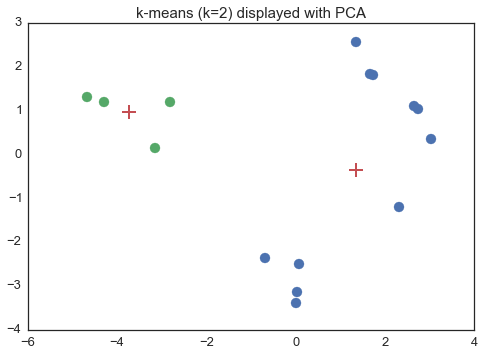

In [13]:
#Create a scatterplot for each k setting, showing the data points and cluster centroids.
#Use PCA for dimensionality reduction.

# PCA for dimensionality reduction
pca = skd.PCA(n_components=2)
filt_pca = pca.fit_transform(df_filt)

# K-means
kmeans_model = skc.KMeans(2).fit(df_filt)
centroids = kmeans_model.cluster_centers_
centroids_pca = pca.transform(centroids)
cluster_labels = kmeans_model.labels_

# Plot the results on 2-D scatterplot with cluster centroids
plt.scatter(filt_pca[cluster_labels==0,0], 
            filt_pca[cluster_labels==0,1],
            s=100, color='b')
plt.scatter(filt_pca[cluster_labels==1,0], 
            filt_pca[cluster_labels==1,1],
            s=100, color='g')
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], marker='+', s=200,
            linewidths=2, color='r')
plt.title('k-means (k=2) displayed with PCA', fontsize=15);


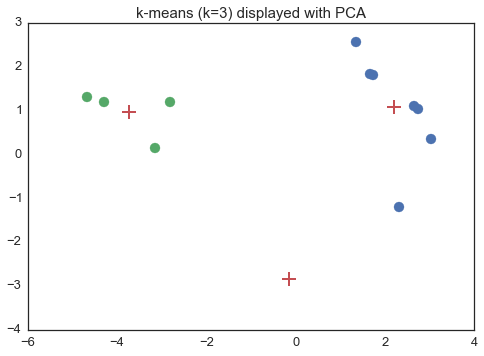

In [14]:
# PCA for dimensionality reduction
pca = skd.PCA(n_components=3)
filt_pca = pca.fit_transform(df_filt)

# K-means
kmeans_model = skc.KMeans(3).fit(df_filt)
centroids = kmeans_model.cluster_centers_
centroids_pca = pca.transform(centroids)
cluster_labels = kmeans_model.labels_

# Plot the results on 2-D scatterplot with cluster centroids
plt.scatter(filt_pca[cluster_labels==0,0], 
            filt_pca[cluster_labels==0,1],
            s=100, color='b')
plt.scatter(filt_pca[cluster_labels==1,0], 
            filt_pca[cluster_labels==1,1],
            s=100, color='g')
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], marker='+', s=200,
            linewidths=2, color='r')
plt.title('k-means (k=3) displayed with PCA', fontsize=15);

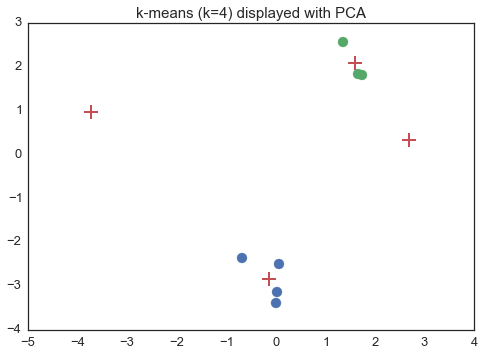

In [15]:
# PCA for dimensionality reduction
pca = skd.PCA(n_components=4)
filt_pca = pca.fit_transform(df_filt)

# K-means
kmeans_model = skc.KMeans(4).fit(df_filt)
centroids = kmeans_model.cluster_centers_
centroids_pca = pca.transform(centroids)
cluster_labels = kmeans_model.labels_

# Plot the results on 2-D scatterplot with cluster centroids
plt.scatter(filt_pca[cluster_labels==0,0], 
            filt_pca[cluster_labels==0,1],
            s=100, color='b')
plt.scatter(filt_pca[cluster_labels==1,0], 
            filt_pca[cluster_labels==1,1],
            s=100, color='g')
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], marker='+', s=200,
            linewidths=2, color='r')
plt.title('k-means (k=4) displayed with PCA', fontsize=15);

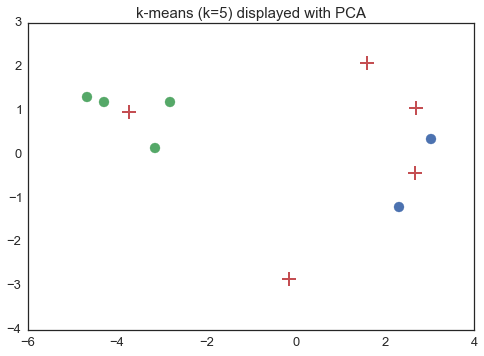

In [16]:
# PCA for dimensionality reduction
pca = skd.PCA(n_components=5)
filt_pca = pca.fit_transform(df_filt)

# K-means
kmeans_model = skc.KMeans(5).fit(df_filt)
centroids = kmeans_model.cluster_centers_
centroids_pca = pca.transform(centroids)
cluster_labels = kmeans_model.labels_

# Plot the results on 2-D scatterplot with cluster centroids
plt.scatter(filt_pca[cluster_labels==0,0], 
            filt_pca[cluster_labels==0,1],
            s=100, color='b')
plt.scatter(filt_pca[cluster_labels==1,0], 
            filt_pca[cluster_labels==1,1],
            s=100, color='g')
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], marker='+', s=200,
            linewidths=2, color='r')
plt.title('k-means (k=5) displayed with PCA', fontsize=15);

In [17]:
#Evaluate the clustering results for each k setting using an appropriate metric.

In [18]:
metrics = ['Age', 'Income', 'HouseholdSize', 'Sales', 'StoreVisit']
X = df_filt[metrics]  # Use all four metrics for the iris dataset
kmeans_model = skc.KMeans(n_clusters=2, random_state=0).fit(X)
silh_score = skm.silhouette_score(X, kmeans_model.labels_)
silh_score  # the Silhouette coefficient

0.61192209640659345

In [19]:
metrics = ['Age', 'Income', 'HouseholdSize', 'Sales', 'StoreVisit']
X = df_filt[metrics]  # Use all four metrics for the iris dataset
kmeans_model = skc.KMeans(n_clusters=3, random_state=0).fit(X)
silh_score = skm.silhouette_score(X, kmeans_model.labels_)
silh_score  # the Silhouette coefficient

0.77306299603876349

In [20]:
metrics = ['Age', 'Income', 'HouseholdSize', 'Sales', 'StoreVisit']
X = df_filt[metrics]  # Use all four metrics for the iris dataset
kmeans_model = skc.KMeans(n_clusters=4, random_state=0).fit(X)
silh_score = skm.silhouette_score(X, kmeans_model.labels_)
silh_score  # the Silhouette coefficient

0.6959795050064348

In [21]:
metrics = ['Age', 'Income', 'HouseholdSize', 'Sales', 'StoreVisit']
X = df_filt[metrics]  # Use all four metrics for the iris dataset
kmeans_model = skc.KMeans(n_clusters=5, random_state=0).fit(X)
silh_score = skm.silhouette_score(X, kmeans_model.labels_)
silh_score  # the Silhouette coefficient

0.54477691599900679

In [22]:
#Determine the best k using at least two approaches introduced in Lab 7.

In [23]:
#Rule of thumb
np.sqrt(len(df_filt) / 2)
np.round(np.sqrt(len(df_filt) / 2))

3.0

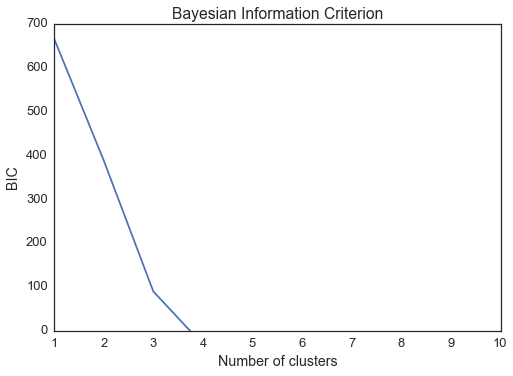

In [24]:
#Information Criterion Approach
X = df_filt
K = range(1,11)
gmms = [skmix.GMM(k).fit(X) for k in K]
bics = [g.bic(X) for g in gmms]
plt.plot(K, bics)
kIdx = np.argmin(bics)  # <-- the selected index
plt.plot(K[kIdx], bics[kIdx], marker='o', markersize=12, 
      markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.ylim(0,plt.ylim()[1])
plt.xlabel('Number of clusters')
plt.ylabel('BIC')
plt.title('Bayesian Information Criterion')

The best k is clearly 3 as determined by the Rule of Thumb and Information Criterion approaches.

(g) Given the following ground truth of clustering, evaluate the above k-means clustering result again (use k=3 only). Use at least two appropriate measurements.

In [25]:
#Perform k-means using scikit-learn package
kmeans_model = skc.KMeans(n_clusters=3)
kmeans_model.fit(df_filt)
centroids = kmeans_model.cluster_centers_
centroids

array([[  1.58972795e+00,   2.12088243e-03,  -2.94883912e-01,
          1.35488253e+00,  -3.22647467e-01,  -9.35414347e-01,
          9.35414347e-01,   5.67930139e-01,  -5.00000000e-01,
         -1.76776695e-01,  -8.16496581e-01,   8.83883476e-01,
         -3.76889181e-02,   2.00000000e+00],
       [ -7.81829164e-01,  -8.34112760e-01,  -7.16146644e-01,
         -9.90508819e-01,   9.58119409e-01,  -7.63603548e-02,
          7.63603548e-02,   2.09990976e-01,  -5.00000000e-01,
          2.02030509e-01,   9.33138950e-01,  -4.04061018e-01,
         -6.03022689e-01,   3.00000000e+00],
       [ -2.21526910e-01,   1.45757645e+00,   1.54814054e+00,
          3.78507900e-01,  -1.35406150e+00,   1.06904497e+00,
         -1.06904497e+00,  -9.35414347e-01,   1.37500000e+00,
         -1.76776695e-01,  -8.16496581e-01,  -1.76776695e-01,
          1.09297862e+00,   1.00000000e+00]])

In [26]:
kmeans_model.labels_

array([0, 1, 0, 2, 2, 1, 2, 0, 1, 0, 1, 1, 2, 1, 1], dtype=int32)

In [46]:
ground_truth = [[170, 198, 239, 384],
                [123, 166, 268, 332],
                [154, 222, 293, 334, 335, 537, 584]]

df_truth = pd.DataFrame(
            [(x,i) for i,c in enumerate(ground_truth) for x in c], 
            columns=['CustomerID','GroundTruth'])
df_truth.set_index('CustomerID', inplace=True)
df_truth = df_truth.sort_index()
labels_truth = df_truth['GroundTruth']

labels_predicted = kmeans_model.labels_
skm.adjusted_rand_score(labels_truth, labels_predicted)

1.0

In [34]:
print(skm.normalized_mutual_info_score(labels_truth, labels_predicted))

1.0


# 2. Open-Ended Analysis

(a) Explore the characteristics of the customers that fall in each cluster, using the ground-truth clusters or any of the clustering results you obtained in 1(e) or 1(f)

In [58]:
df_binary = pd.concat((df_filt_2, df_filt['cluster_label']), axis=1)
df_binary

,Age,Income,HouseholdSize,Sales,StoreVisit,Female,Male,Cash,Credit,Debit,Beer,Spirit,Wine,cluster_label
CustomerID,,,,,,,,,,,,,,
123,60,45000,2,300,10,0,1,1,0,0,0,1,0,2
154,21,21000,1,46,18,0,1,0,0,1,1,0,0,3
166,72,48000,2,290,11,0,1,1,0,0,0,1,0,2
170,36,90000,5,190,4,1,0,0,1,0,0,0,1,1
198,34,85000,4,180,6,1,0,0,0,1,0,0,1,1
222,21,21000,1,75,21,0,1,1,0,0,0,1,0,3
239,35,75000,4,200,5,1,0,0,1,0,0,1,0,1
268,68,44000,2,280,13,0,1,0,0,1,0,1,0,2
293,23,30000,1,60,22,0,1,0,0,1,1,0,0,3


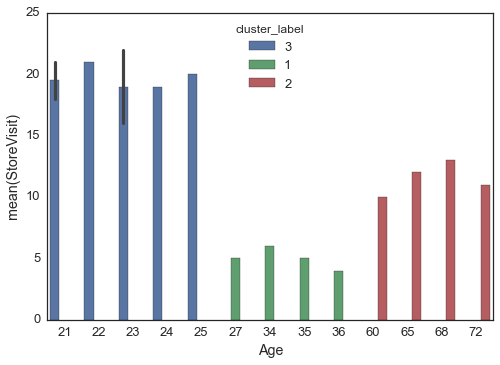

In [63]:
df_age = df_binary.sort(['Age'])

sns.barplot(x='Age', y='StoreVisit', data=df_age, hue='cluster_label')
plt.title("Number of Store Visits by Age")

This barplot shows the number of Store Visits by Age, grouped by cluster. It shows that cluster 3 has the highest number of store visits

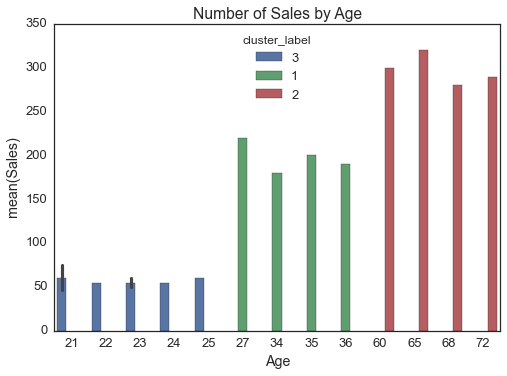

In [68]:
sns.barplot(x='Age', y='Sales', data=df_age, hue='cluster_label')
plt.title("Number of Sales by Age")

This barplot shows the Number of Sales by Age, grouped by cluster. It shows that Cluster two has the highest number of sales.

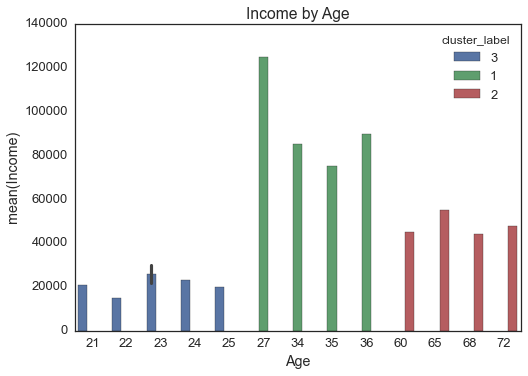

In [69]:
sns.barplot(x='Age', y='Income', data=df_age, hue='cluster_label')
plt.title("Income by Age")

This barplot shows the Income by Age, grouped by cluster. It shows that cluser 1 has the highest income followed by cluster 2 with the second-highest.

Cluster 1 has the lowest number of Store Visits, the medium number of Sales, and the highest income.

Cluster 2 has the middle number of Store Visits, the highest number of Sales and the middle income. This shows that the oldest age group is spending the most.

Cluster 3 has the highest number of Store Visits but the lowest number of Sales and the lowest income. This shows that the youngest age group is frequenting the store the most but spending the least. 

(b) Based on your analysis, recommend at least two strategies for improving your company's alcohol sales in this region.

Cluster 1 has the highest income but has the middle amount of sales. The store should spend more time targeting this age group because they have the highest and probably most disposable income. Cluster 2 already has the highest number of sales, so the store does not need to focus on this group. Cluster 3 spends the least on alcohol and also has the lowest income. The company should take this into consideration because cluster 3 clearly cannot afford to spend a lot of money on alcohol, so the company may benefit by stocking some inexpensive alcohol for these particular customers.

# 3. General Questions

3a. In what kind of scenarios is each of the following distance functions preferred?

Euclidean distance: The Euclidean distance or Euclidean metric is the "ordinary" distance between two points in Euclidean space. Euclidean is used for going the direct route to a point.

Manhattan (city block) distance: The distance between two points in a grid based on a strictly horizontal and/or vertical path, as opposed to the diagonal distance. The Manhattan distance is the simple sum of the horizontal and vertical components.

Jaccard distance: The Jaccard distance is a statistic used for comparing the similarity and diversity of sample sets. The Jaccard distance, which measures dissimilarity between sample sets, is complementary to the Jaccard coefficient and is obtained by subtracting the Jaccard coefficient from 1, or, equivalently, by dividing the difference of the sizes of the union and the intersection of two sets by the size of the union

Cosine distance: Cosine similarity is a measure of similarity between two vectors of an inner product space that measures the cosine of the angle between them. The cosine of 0° is 1, and it is less than 1 for any other angle. Cosine distance is a term often used for the complement in positive space. 

*Answers from Wikipedia

3b. List at least three methods for determining the number of clusters given a dataset. List the pros and cons for each method.

The Elbow Method:

Pro: The elbow method is a quick and easy test. If you plot the percentage of variance explained by the clusters against the number of clusters, the first clusters will explain a lot of variance, but at some point the marginal gain will drop, giving an angle in the graph. The number of clusters is chosen at this point.

Con: The "elbow" cannot always be unambiguously/easily identified.


Information Criterion Approach:

Pro: Random (uniform) label assignments have a AMI score close to 0.0 for any value of n_clusters and n_samples. Bounded range [0, 1]: Values close to zero indicate two label assignments that are largely independent, while values close to one indicate significant agreement. Further, values of exactly 0 indicate purely independent label assignments and a AMI of exactly 1 indicates that the two label assignments are equal (with or without permutation).
No assumption is made on the cluster structure: can be used to compare clustering algorithms such as k-means which assumes isotropic blob shapes with results of spectral clustering algorithms which can find cluster with “folded” shapes.

Con: MI-based measures require the knowledge of the ground truth classes while almost never available in practice or requires manual assignment by human annotators (as in the supervised learning setting).


The Silhouette Approach:

Pro: The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters. The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

Con: It is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.

*Answers from Wikipedia